# How to use `contaminante`

This tutorial will show you how to use `contaminante`. If you'd like to try it yourself, you can use `contaminante` online, in the cloud, for free! Click [here](https://colab.research.google.com/github/christinahedges/contaminante/blob/master/tutorials/Colaboratory-Notebook.ipynb) to run `contaminante` online using Google's Colaboratory. 

## Using `contaminante` on *Kepler* data

To demonstrate `contaminante` we'll first use *Kepler* data. First we'll need a target to try `contaminante` on. I've chosen *KIC 6804648*. This target was observed during the prime *Kepler* mission, and was flagged as a planet candidate. In fact, the target has a contaminating eclipsing binary. This binary is only obvious in some of the *Kepler* quarters. 

Below we run the target through `contaminante`. Running this cell should take less than 5 minutes.

In [22]:
import contaminante as ct
import lightkurve as lk
import numpy as np

In [135]:
# from model (single, rho fit)
# https://drive.google.com/drive/folders/1LOp_pYwHXThdoU3mpPn350cqvvm1C7kG
tic, sector = 18016577, 48  # with the period, the expected dip in sector 22 occurs in data gap, so it is not helpful
period = 35.8648067
t0 = 2630.3051774
duration = 4.6054948 

# from s0048-s0048:TCE1
# tic, sector = 18016577, [22, 48]
# period=19.769411
# t0=2610.5497,
# duration=9.2324


In [136]:
download_dir="data"  # where to store the TPFs

# one-time config for query cache if supported in the lightkurve used
if hasattr(lk.search, "sr_cache"): 
    lk.search.sr_cache.cache_dir = download_dir

tpfs_all = lk.search_targetpixelfile(f"TIC {tic}", sector=sector).download_all(download_dir=download_dir)
print("TIC sector cadence(min), num. cadence")
for t in tpfs_all:
    print(f"TIC {t.targetid}", t.sector, f"{(np.median(np.diff(t.time.value)) * 24 * 60):.0f}", len(t))

TIC sector cadence(min), num. cadence
TIC 18016577 48 2 18989


In [138]:
# filter out unhelpful tpfs (sector 22 has both 30-minute and 2-minute TPFs)
tpfs = tpfs_all
# tpfs = tpfs_all[0, 2]

print("TIC sector cadence(min), num. cadence")
for t in tpfs:
    print(f"TIC {t.targetid}", t.sector, f"{(np.median(np.diff(t.time.value)) * 24 * 60):.0f}", len(t))

TIC sector cadence(min), num. cadence
TIC 18016577 48 2 18989


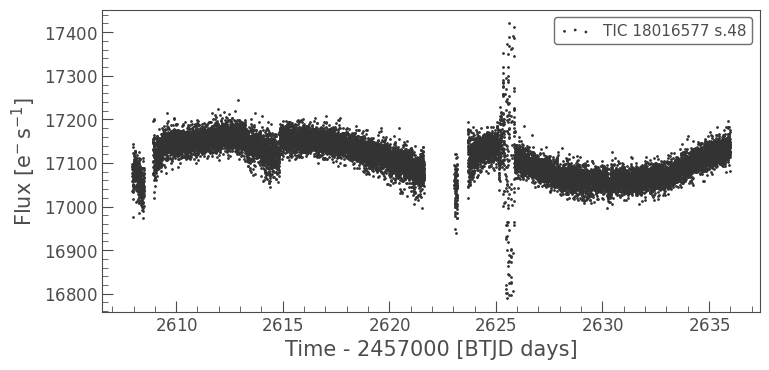

In [139]:
# Rough LCs as a reminder of what we are working with
axs = [t.to_lightcurve().remove_outliers(sigma=7).scatter(label=f"TIC {t.targetid} s.{t.sector}") for t in tpfs];

Modeling TPFs:   0%|                                                         | 0/1 [00:00<?, ?it/s]C:\dev\_juypter\contaminante\src\contaminante\contaminante.py:256: RuntimeWarning: invalid value encountered in multiply
  transit_pixels_err = np.zeros(tpf.flux.shape[1:]) * np.inf
C:\dev\_juypter\contaminante\src\contaminante\contaminante.py:257: RuntimeWarning: invalid value encountered in multiply
  chi_ratio = np.zeros(tpf.flux.shape[1:]) * np.inf
C:\dev\_juypter\contaminante\src\contaminante\contaminante.py:547: RuntimeWarning: invalid value encountered in log10
  np.log10(np.nanmedian(np.nan_to_num(tpf.flux.value), axis=0)),
Modeling TPFs: 100%|█████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.98s/it]


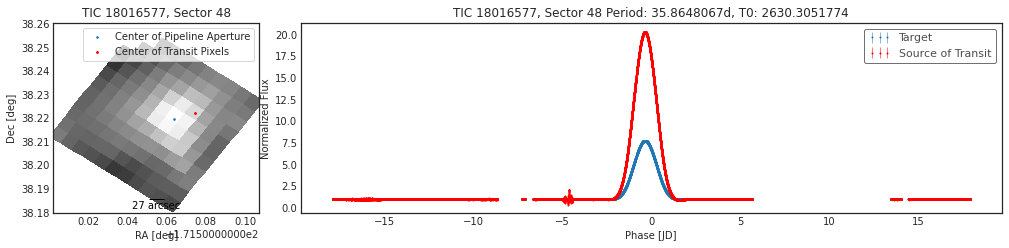

In [150]:
# Note: for TESS data, contaminate requires tpfs have been background corrected

result = ct.calculate_contamination(tpfs, period, t0, duration, plot=True,
#                                     sigma=3,  # default: 5
#                                     spline_period=0.75,  # defualt: 1
#                                     cbvs=True,  # default: True
#                                     sff=False,  # always false for TESS
                                   );

In [151]:
for r in result:
    print("Sector", r["target_lc"].sector, " centroid shift:", r.get("centroid_shift"))

Sector 48  centroid shift: (<Quantity 39.41027947 arcsec>, <Quantity 0.00099762 arcsec>)


Aperture used by `contamiante`:

if a large aperture is chosen for contaminator, transit depth from `contaminate` would be shallower

For sector  48


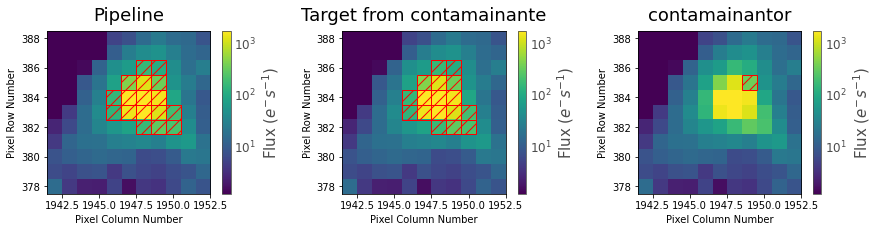

In [152]:
import matplotlib.pyplot as plt

idx = -1 # the sector to show
print("For sector ", result[idx]["target_lc"].sector, )

# fig, ax = plt.subplots(1, 2, figsize=(10, 3))
# tpfs[idx].plot(aperture_mask=tpfs[idx].pipeline_mask, scale='log', ax=ax[0], title='Pipeline')
# tpfs[idx].plot(aperture_mask=result[idx]['contaminator_aper'], scale='log', ax=ax[1], title='contamainante');

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
tpfs[idx].plot(aperture_mask=tpfs[idx].pipeline_mask, scale='log', ax=ax[0], title='Pipeline')
tpfs[idx].plot(aperture_mask=result[idx]['target_aper'], scale='log', ax=ax[1], title='Target from contamainante')
tpfs[idx].plot(aperture_mask=result[idx]['contaminator_aper'], scale='log', ax=ax[2], title='contamainantor');

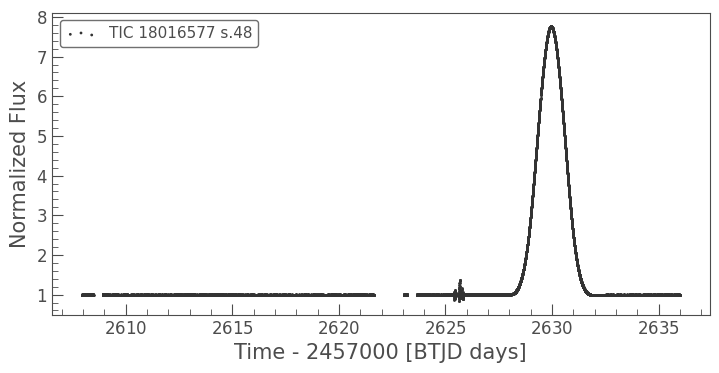

In [153]:
for r in result:
    lc = r.get("target_lc")
    if lc is not None:
        lc.scatter(label=f"{lc.label} s.{lc.sector}");
    else:
        print(f"No target lc")

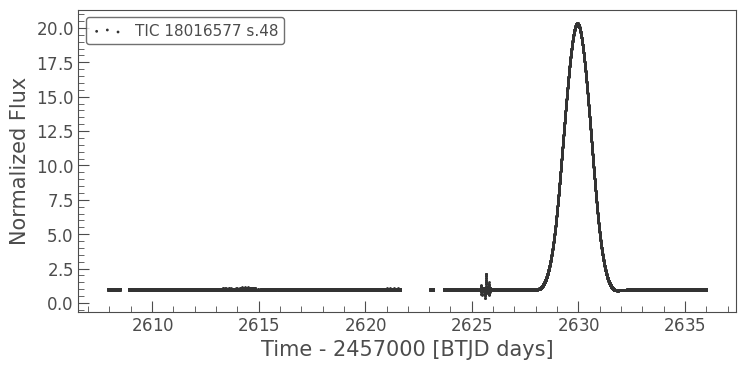

In [154]:
for r in result:
    lc = r.get("contaminator_lc")
    if lc is not None:
        lc.scatter(label=f"{lc.label} s.{lc.sector}");
    else:
        print(f"Sector {r['target_lc'].sector} has no contaminator lc")

Transit signficance at pixel level: to visualize where the dip comes from

For sector  48


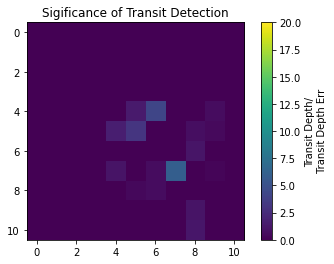

In [155]:
print("For sector ", result[idx]["target_lc"].sector, )

plt.imshow(result[idx]['transit_depth']/result[idx]['transit_depth_err'], vmin=0, vmax=20)
plt.title("Sigificance of Transit Detection")
cbar = plt.colorbar()
cbar.set_label("Transit Depth/\n Transit Depth Err")

In [75]:
tpfs[idx].interact_sky(notebook_url="localhost:8890");

Using `contaminante` we can see two pieces of evidence that this target is contaminated.
1. There is a significant offset between the center of the **target** (blue dot) in the image, and the **source of the transiting signal** (red dot). **NOTE: The blue dot is the weighted average of the flux inside the pipeline aperture, for crowded sources this may not be accurate.**
2. There is a significant difference between the **target** phase curve (blue phase curve) and the **source of the transiting signal** phase curve (red phase curve).

We name the source of the transiting signal that `contaminante` finds the "contaminator".

The result is a list of dictionaries contains the depth and positions of the target and the "contamintor" for each quarter, including errors. The user is encouraged to 1) look at the phase curves 2) look at the positions of the contaminator and target and 3) the transit depths of the contaminator and the target before claiming that a target is contaminated. In the above cases there is a significant difference between the contaminator and the target.

## Usage notes

1. **Different quarters, campaigns and sectors.** If a target has multiple quarters, campaigns or sectors you can expect each dataset to have some slight offset, due to the target falling on different pixels.

2. **Shallower contaminator light curves.** `Contaminante` looks at each pixel individually to see if there is a significant transit signal. Because faint pixels can contribute a transiting signal at a lower, less significant level, some faint pixels can be missed in contaminante. In the case that the contaminator light curve is **shallower** than the target light curve, it is likely that some faint pixels have been missed from the optimum aperture. This does not indicate that there is any contamination.

